In [2]:
from keras.models import model_from_json, Sequential, Model
from keras.utils import np_utils
from keras.layers import LSTM, Dense , Dropout, CuDNNLSTM
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split
import sys
sys.path.append("../")
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import utils
import pandas as pd
%matplotlib inline

np.random.seed(123)

## Load models

In [3]:
# load learned model
generator = model_from_json(open('../models/generator_model_bp_84.json').read())
generator.load_weights('../models/generator_weight_bp_84.h5')
discriminator = model_from_json(open('../models/discriminator_model_bp_84.json').read())
discriminator.load_weights('../models/discriminator_weight_bp_84.h5')

W1008 20:19:35.984517 139966693762816 deprecation_wrapper.py:119] From /home/hiroshi_koshimizu/miniconda3/envs/gan-research/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1008 20:19:36.445602 139966693762816 deprecation_wrapper.py:119] From /home/hiroshi_koshimizu/miniconda3/envs/gan-research/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1008 20:19:36.880450 139966693762816 deprecation_wrapper.py:119] From /home/hiroshi_koshimizu/miniconda3/envs/gan-research/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1008 20:19:36.881471 139966693762816 deprecation_wrapper.py:119] From /home/hiroshi_koshimizu/miniconda3/envs/gan-research/lib/python3.6/site-packages/k

## Paramset

In [4]:
batch_size = 64
input_dim = 3
seq_length = 84
latent_dim = 500
num_classes = 4
ht_ratio = 0.3

## Synthesis data

In [5]:
np.random.dirichlet([1,0.2,0.2,0.2], batch_size).argmax(axis = 1)

array([0, 3, 3, 1, 2, 0, 0, 0, 3, 0, 0, 0, 1, 0, 3, 2, 0, 0, 0, 0, 0, 0,
       2, 1, 1, 0, 0, 0, 0, 1, 0, 2, 2, 0, 1, 3, 0, 1, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [6]:
def generate_samples(num_samples):
    gen_x = []
    gen_y = []
    gen_iter = (num_samples // batch_size) + 1
    for i in range(0, gen_iter):
        noise = np.random.normal(0, 1, (batch_size, seq_length, latent_dim))
        #sample_c = np.random.randint(0, num_classes, batch_size)
        #sample_c = np.random.binomial(1, ht_ratio, batch_size)
        sample_c = np.random.dirichlet([1,0.25,0.25,0.25], batch_size).argmax(axis = 1)
        gen_x.extend(generator.predict_on_batch([noise, sample_c]))
        gen_y.extend(sample_c)
    gen_x_arr = np.array(gen_x)
    gen_y_arr = np.array(gen_y)
    return (gen_x_arr[:num_samples], gen_y_arr[:num_samples])

In [7]:
gen_x, gen_y = generate_samples(num_samples=3223)
mms = np.load('/home/hiroshi_koshimizu/work/RCGAN/bp_data_mms_84.npz')
mms = ( (gen_x.reshape(gen_x.shape[0], gen_x.shape[1] * gen_x.shape[2]) + 1)/2 ) * (mms['data_max'] - mms['data_min']) + mms['data_min']
gen_x = mms.reshape( gen_x.shape[0], gen_x.shape[1], gen_x.shape[2] )
np.savez('./synthetic_bp_84.npz', x = gen_x, y = gen_y)

In [8]:
a = pd.DataFrame(gen_y) 
a[a[0] == 3].index.tolist()[30:50]

[303,
 325,
 329,
 338,
 339,
 343,
 375,
 376,
 379,
 390,
 392,
 409,
 417,
 441,
 446,
 451,
 454,
 460,
 485,
 488]

/home/hiroshi_koshimizu/miniconda3/envs/gan-research/lib/python3.6/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


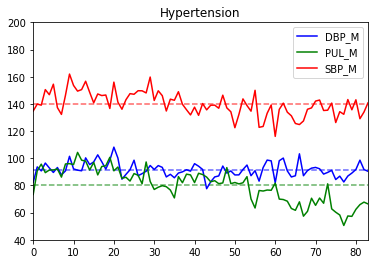

(None, 3)

In [9]:
make_target = 375
#303
tmp = pd.DataFrame(
    gen_x[make_target], 
    columns = ['DBP_E',	'DBP_M', 'PUL_E', 'PUL_M', 'SBP_E', 'SBP_M']
)
tmp[['DBP_M','PUL_M','SBP_M']].plot(ylim = (40, 200), title = 'Hypertension', colors = ['b','g','r'])
plt.hlines(tmp[['DBP_M','PUL_M','SBP_M']].mean(axis = 0), 0, 84, colors = ['b','g','r'],linestyles="dashed", alpha = 0.6)
plt.show(), gen_y[make_target]

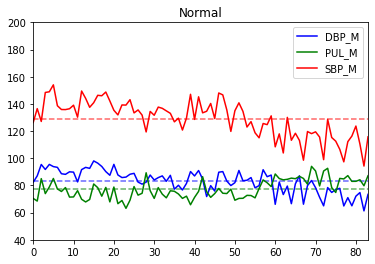

(None, 0)

In [66]:
make_target = 24
tmp = pd.DataFrame(
    gen_x[make_target], 
    columns = ['DBP_E',	'DBP_M', 'PUL_E', 'PUL_M', 'SBP_E', 'SBP_M']
)
tmp[['DBP_M','PUL_M','SBP_M']].plot(ylim = (40, 200), title = 'Normal', colors = ['b','g','r'])
plt.hlines(tmp[['DBP_M','PUL_M','SBP_M']].mean(axis = 0), 0, 84, colors = ['b','g','r'],linestyles="dashed", alpha = 0.6)
plt.show(), gen_y[make_target]

## Read real data

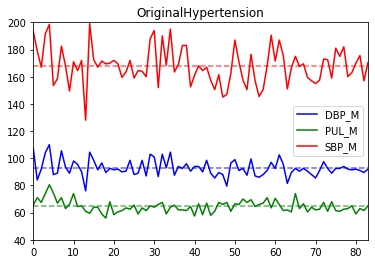

(None, 3)

In [21]:
original = np.load('/home/hiroshi_koshimizu/work/RCGAN/inputs/bp_data_84.npz')

make_target = 103
tmp = pd.DataFrame(
    original['x'][make_target], 
    columns = ['DBP_E',	'DBP_M', 'PUL_E', 'PUL_M', 'SBP_E', 'SBP_M']
)
tmp[['DBP_M','PUL_M','SBP_M']].plot(ylim = (40, 200), title = 'OriginalHypertension', colors = ['b','g','r'])
plt.hlines(tmp[['DBP_M','PUL_M','SBP_M']].mean(axis = 0), 0, 84, colors = ['b','g','r'],linestyles="dashed", alpha = 0.6)
plt.show(), original['y'][make_target]

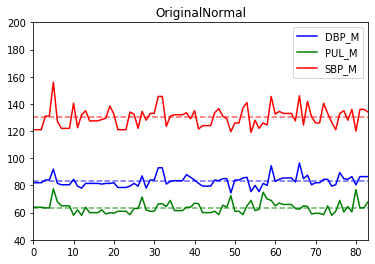

(None, 0)

In [16]:
make_target = 107
tmp = pd.DataFrame(
    original['x'][make_target], 
    columns = ['DBP_E',	'DBP_M', 'PUL_E', 'PUL_M', 'SBP_E', 'SBP_M']
)
tmp[['DBP_M','PUL_M','SBP_M']].plot(ylim = (40, 200), title = 'OriginalNormal', colors = ['b','g','r'])
plt.hlines(tmp[['DBP_M','PUL_M','SBP_M']].mean(axis = 0), 0, 84, colors = ['b','g','r'],linestyles="dashed", alpha = 0.6)
plt.show(), original['y'][make_target]

## Dist: Synthesis - Real

In [22]:
def make_graph2d(data, x_axis, y_axis, x_name, y_name, c = 'b'):
    plt.scatter(data[:,:,x_axis].ravel(), data[:,:,y_axis].ravel(), alpha = 0.2, marker = 'x', c = c)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    
    plt.xlim(30, 140)
    plt.ylim(30, 225)
    plt.show()

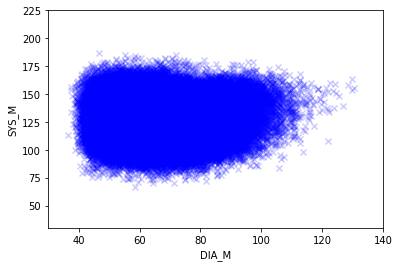

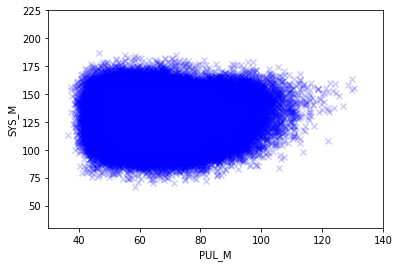

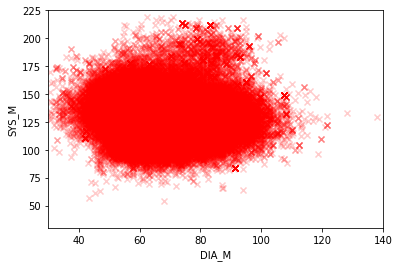

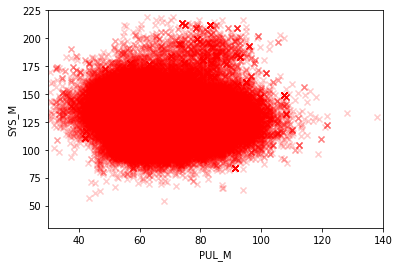

In [24]:
make_graph2d(gen_x, x_axis=3, y_axis=5, x_name = 'DIA_M', y_name ='SYS_M')
make_graph2d(gen_x, x_axis=3, y_axis=5, x_name = 'PUL_M', y_name ='SYS_M')
make_graph2d(original['x'], x_axis=3, y_axis=5, x_name = 'DIA_M', y_name ='SYS_M', c = 'r')
make_graph2d(original['x'], x_axis=3, y_axis=5, x_name = 'PUL_M', y_name ='SYS_M', c = 'r')

Normal


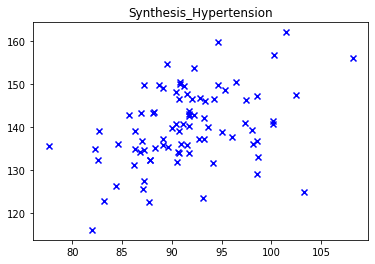

          DBP_M     SBP_M     PUL_M
DBP_M  1.000000  0.392543  0.293985
SBP_M  0.392543  1.000000  0.455056
PUL_M  0.293985  0.455056  1.000000


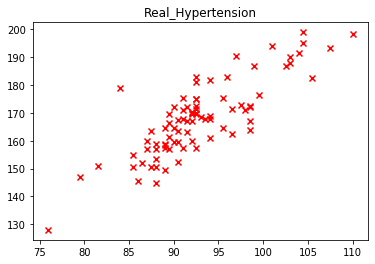

          DBP_M     SBP_M     PUL_M
DBP_M  1.000000  0.834064  0.244532
SBP_M  0.834064  1.000000  0.156933
PUL_M  0.244532  0.156933  1.000000


In [64]:
print('Normal')
make_target = 375
tmp = pd.DataFrame(
    gen_x[make_target], 
    columns = ['DBP_E',	'DBP_M', 'PUL_E', 'PUL_M', 'SBP_E', 'SBP_M']
)
plt.scatter(tmp['DBP_M'].ravel(), tmp['SBP_M'].ravel(), marker = 'x', c = 'b')
plt.title('Synthesis_Hypertension')
#plt.xlim(60,100)
#plt.ylim(90,160)
plt.show()
print(tmp[['DBP_M','SBP_M', 'PUL_M']].corr())
#make_graph2d(tmp, x_axis=3, y_axis=5, x_name = 'DIA_M', y_name ='SYS_M')
#make_graph2d(tmp, x_axis=3, y_axis=5, x_name = 'PUL_M', y_name ='SYS_M')

make_target = 103
tmp = pd.DataFrame(
    original['x'][make_target], 
    columns = ['DBP_E',	'DBP_M', 'PUL_E', 'PUL_M', 'SBP_E', 'SBP_M']
)
#sns.regplot(tmp['DBP_M'].ravel(), tmp['SBP_M'].ravel(), marker = 'x')
plt.scatter(tmp['DBP_M'].ravel(), tmp['SBP_M'].ravel(), marker = 'x', c = 'r')
plt.title('Real_Hypertension')
#plt.xlim(75,100)
#plt.ylim(115,160)
plt.show()
print(tmp[['DBP_M','SBP_M', 'PUL_M']].corr())

Normal


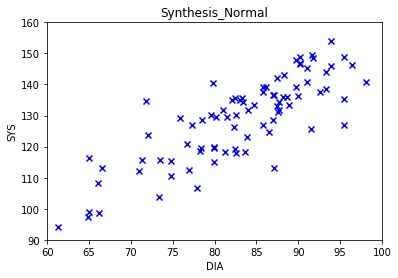

          DBP_M     SBP_M     PUL_M
DBP_M  1.000000  0.818807 -0.387837
SBP_M  0.818807  1.000000 -0.555421
PUL_M -0.387837 -0.555421  1.000000


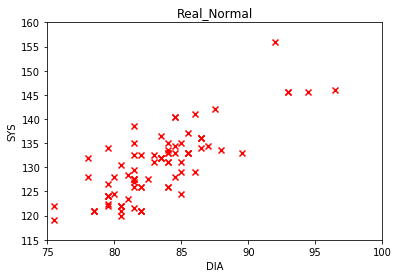

          DBP_M     SBP_M     PUL_M
DBP_M  1.000000  0.798036  0.233175
SBP_M  0.798036  1.000000  0.074845
PUL_M  0.233175  0.074845  1.000000


In [65]:
print('Normal')
make_target = 24
tmp = pd.DataFrame(
    gen_x[make_target], 
    columns = ['DBP_E',	'DBP_M', 'PUL_E', 'PUL_M', 'SBP_E', 'SBP_M']
)
plt.scatter(tmp['DBP_M'].ravel(), tmp['SBP_M'].ravel(), marker = 'x', c = 'b')
plt.title('Synthesis_Normal')
plt.xlim(60,100)
plt.xlabel('DIA')
plt.ylim(90,160)
plt.ylabel('SYS')
plt.show()
print(tmp[['DBP_M','SBP_M', 'PUL_M']].corr())
#make_graph2d(tmp, x_axis=3, y_axis=5, x_name = 'DIA_M', y_name ='SYS_M')
#make_graph2d(tmp, x_axis=3, y_axis=5, x_name = 'PUL_M', y_name ='SYS_M')

make_target = 107
tmp = pd.DataFrame(
    original['x'][make_target], 
    columns = ['DBP_E',	'DBP_M', 'PUL_E', 'PUL_M', 'SBP_E', 'SBP_M']
)
#sns.regplot(tmp['DBP_M'].ravel(), tmp['SBP_M'].ravel(), marker = 'x')
plt.scatter(tmp['DBP_M'].ravel(), tmp['SBP_M'].ravel(), marker = 'x', c = 'r')
plt.title('Real_Normal')
plt.xlim(75,100)
plt.xlabel('DIA')
plt.ylim(115,160)
plt.ylabel('SYS')
plt.show()
print(tmp[['DBP_M','SBP_M', 'PUL_M']].corr())

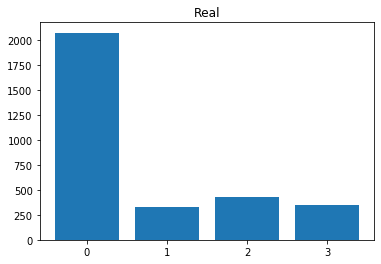

Text(0.5, 1.0, 'Sythesis')

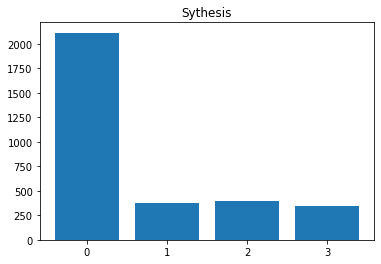

In [39]:
plt.bar(
    np.unique(original['y']).astype('str'), 
    pd.Series(original['y']).value_counts(sort = False).values,
)
plt.title('Real')
plt.show()
plt.bar(
    np.unique(gen_y).astype('str'), 
    pd.Series(gen_y).value_counts(sort = False).values,
)
plt.title('Sythesis')

## Train discremator 

In [40]:
# load synthetic data for training
npz = np.load('/home/hiroshi_koshimizu/work/RCGAN/ipynbs_koshimizu/synthetic_bp_84.npz')
X_train, y_train = npz['x'], npz['y']
print(X_train.shape)
print(y_train.shape)

# load real data for testing
npz = np.load('/home/hiroshi_koshimizu/work/RCGAN/inputs/bp_data_84.npz')
X_eval, y_eval = npz['x'], npz['y']
X_eval, X_valid, y_eval, y_valid = train_test_split(X_eval, y_eval, test_size = 0.3)
print(X_eval.shape)
print(y_eval.shape)
print(X_valid.shape)
print(y_valid.shape)

# hyper parameter for training
input_dim = X_train.shape[2]
sequence = X_train.shape[1]
labels = 4
hidden_dim = 500

# to one-hot vector
y_train = np_utils.to_categorical(y_train, labels)
y_eval = np_utils.to_categorical(y_eval, labels)
y_valid = np_utils.to_categorical(y_valid, labels)

(3223, 84, 6)
(3223,)
(2228, 84, 6)
(2228,)
(955, 84, 6)
(955,)


In [41]:
model = Sequential()
model.add(CuDNNLSTM(units=hidden_dim,
               batch_input_shape=(None, sequence, input_dim),
               return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(labels, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer="Adam",
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

W1008 14:15:50.393621 139807565780736 deprecation.py:506] From /home/hiroshi_koshimizu/miniconda3/envs/gan-research/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1008 14:15:50.416729 139807565780736 deprecation_wrapper.py:119] From /home/hiroshi_koshimizu/miniconda3/envs/gan-research/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [42]:
fit = model.fit(X_train, y_train,
          batch_size=64,
          epochs=100,
          validation_data=[X_valid, y_valid],
          callbacks=[early_stopping])

W1008 14:15:50.543757 139807565780736 deprecation.py:323] From /home/hiroshi_koshimizu/miniconda3/envs/gan-research/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 3223 samples, validate on 955 samples
Epoch 1/100
3223/3223 [==============================] - 2s 618us/step - loss: 0.7072 - acc: 0.7183 - val_loss: 0.6375 - val_acc: 0.7351
Epoch 2/100
3223/3223 [==============================] - 1s 316us/step - loss: 0.4155 - acc: 0.8349 - val_loss: 0.4805 - val_acc: 0.8094
Epoch 3/100
3223/3223 [==============================] - 1s 315us/step - loss: 0.2993 - acc: 0.8818 - val_loss: 0.6478 - val_acc: 0.7131
Epoch 4/100
3223/3223 [==============================] - 1s 315us/step - loss: 0.3062 - acc: 0.8821 - val_loss: 0.7634 - val_acc: 0.6806
Epoch 5/100
3223/3223 [==============================] - 1s 316us/step - loss: 0.2949 - acc: 0.8868 - val_loss: 0.5115 - val_acc: 0.8000
Epoch 6/100
3223/3223 [==============================] - 1s 315us/step - loss: 0.2104 - acc: 0.9243 - val_loss: 0.5619 - val_acc: 0.8021
Epoch 7/100
3223/3223 [==============================] - 1s 316us/step - loss: 0.1868 - acc: 0.9327 - val_loss: 0.5948 - val_acc: 0

              precision    recall  f1-score   support

           0       0.95      0.81      0.87       644
           1       0.50      0.96      0.66       124
           2       0.55      0.72      0.63        98
           3       0.82      0.36      0.50        89

   micro avg       0.78      0.78      0.78       955
   macro avg       0.70      0.71      0.66       955
weighted avg       0.84      0.78      0.79       955
 samples avg       0.78      0.78      0.78       955



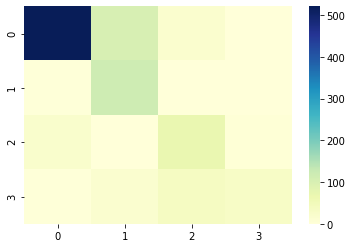

In [43]:
print(classification_report(y_valid, np_utils.to_categorical(model.predict_classes(X_valid))))

sns.heatmap(
    confusion_matrix(y_valid.argmax(axis = 1), np_utils.to_categorical(model.predict_classes(X_valid)).argmax(axis = 1)),
    cmap = 'YlGnBu'
)

In [44]:
model_o = Sequential()
model_o.add(CuDNNLSTM(units=hidden_dim,
               batch_input_shape=(None, sequence, input_dim),
               return_sequences=False))
model_o.add(Dropout(0.2))
model_o.add(Dense(labels, activation='softmax'))
model_o.compile(loss="categorical_crossentropy", optimizer="Adam",
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [45]:
fit = model_o.fit(X_eval, y_eval,
          batch_size=64,
          epochs=100,
          validation_data=[X_valid, y_valid],
          callbacks=[early_stopping])

Train on 2228 samples, validate on 955 samples
Epoch 1/100
2228/2228 [==============================] - 1s 645us/step - loss: 0.8991 - acc: 0.6539 - val_loss: 0.7033 - val_acc: 0.8000
Epoch 2/100
2228/2228 [==============================] - 1s 329us/step - loss: 0.5862 - acc: 0.7496 - val_loss: 0.6026 - val_acc: 0.7634
Epoch 3/100
2228/2228 [==============================] - 1s 333us/step - loss: 0.5044 - acc: 0.7980 - val_loss: 0.3422 - val_acc: 0.8733
Epoch 4/100
2228/2228 [==============================] - 1s 340us/step - loss: 0.3877 - acc: 0.8452 - val_loss: 0.3877 - val_acc: 0.8513
Epoch 5/100
2228/2228 [==============================] - 1s 333us/step - loss: 0.3721 - acc: 0.8528 - val_loss: 0.3230 - val_acc: 0.8691
Epoch 6/100
2228/2228 [==============================] - 1s 334us/step - loss: 0.2913 - acc: 0.8806 - val_loss: 0.2842 - val_acc: 0.8974
Epoch 7/100
2228/2228 [==============================] - 1s 336us/step - loss: 0.2901 - acc: 0.8833 - val_loss: 0.2501 - val_acc: 0

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       644
           1       0.76      0.91      0.83       124
           2       0.94      0.50      0.65        98
           3       0.72      0.94      0.82        89

   micro avg       0.90      0.90      0.90       955
   macro avg       0.85      0.83      0.81       955
weighted avg       0.91      0.90      0.89       955
 samples avg       0.90      0.90      0.90       955



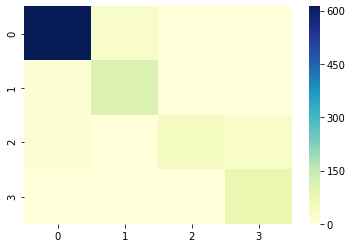

In [46]:
print(classification_report(y_valid, np_utils.to_categorical(model_o.predict_classes(X_valid))))
sns.heatmap(
    confusion_matrix(y_valid.argmax(axis = 1), np_utils.to_categorical(model_o.predict_classes(X_valid)).argmax(axis = 1)),
    cmap = 'YlGnBu'
)

## 個別確認

In [47]:
gan_chk = pd.concat(
    [
        pd.Series(y_valid.argmax(axis = 1), name = 'Real'), 
        pd.Series( 
            np_utils.to_categorical(model.predict_classes(X_valid)).argmax(axis = 1), name = 'Synthesis Trained'
        )
    ],
    axis = 1
)
gan_chk['Match'] = (gan_chk['Real'] == gan_chk['Synthesis Trained'])

In [48]:
gan_chk.groupby(['Match', 'Real']).count()

Synthesis Trained
Match Real                   
False 0                   123
      1                     5
      2                    27
      3                    57
True  0                   521
      1                   119
      2                    71
      3                    32

In [49]:
gan_chk[
    np.logical_and(gan_chk['Real'] == 3, gan_chk['Match'] == False)
].head(10)

,Real,Synthesis Trained,Match
1,3,2,False
11,3,0,False
19,3,2,False
35,3,2,False
45,3,2,False
48,3,1,False
49,3,2,False
66,3,2,False
76,3,2,False
109,3,0,False


In [50]:
def indivi_key(index_no):
    tmp = pd.DataFrame(
        X_valid[index_no], 
        columns = ['PUL_E', 'PUL_M', 'DIA_E', 'DIA_M', 'SYS_E', 'SYS_M']
    )
    
    tmp[['PUL_M', 'DIA_M', 'SYS_M']].plot(ylim = (40, 200), colors = ['b','g','r'], title = index_no)

    plt.hlines(tmp.loc[:, ['PUL_M', 'DIA_M', 'SYS_M']].mean(axis = 0), 0, 84, colors = ['b','g','r'], linestyles="dashed", alpha = 0.6)
    plt.show() 
    print(y_valid[index_no], X_valid[index_no].mean(axis = 0))

## しきい値付近

/home/hiroshi_koshimizu/miniconda3/envs/gan-research/lib/python3.6/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


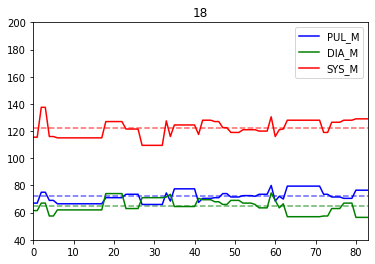

[1. 0. 0. 0.] [ 72.00595238  72.04166667  65.88690476  64.58333333 119.69047619
 121.98214286]


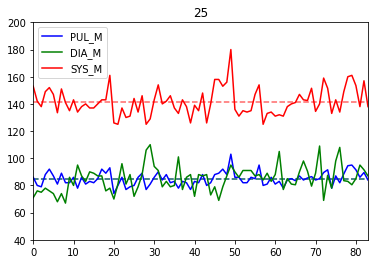

[0. 1. 0. 0.] [ 73.64880952  84.88690476  75.86904762  85.01785714 127.10119048
 141.57142857]


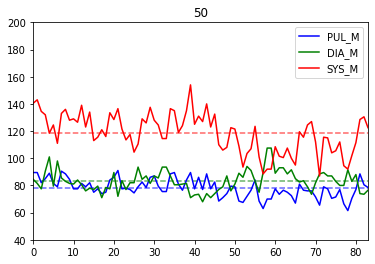

[1. 0. 0. 0.] [ 78.06547619  78.17261905  81.78571429  83.29761905 127.94642857
 118.45238095]


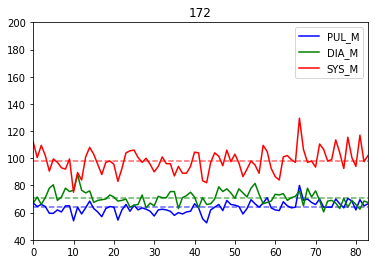

[1. 0. 0. 0.] [61.20238095 63.76785714 68.58333333 71.0297619  97.9702381  97.97619048]


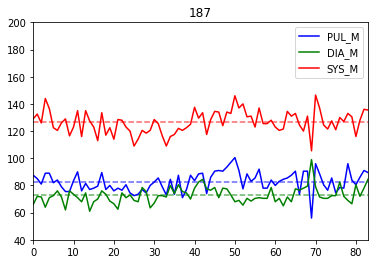

[1. 0. 0. 0.] [ 70.47619048  82.75595238  78.29761905  72.86904762 117.80952381
 126.36904762]


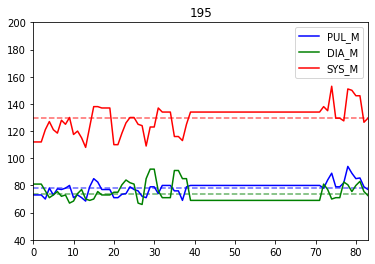

[1. 0. 0. 0.] [ 71.86309524  78.45833333  68.99404762  73.69642857 121.29761905
 129.73809524]


In [51]:
indivi_key(18)
indivi_key(25)
indivi_key(50)
indivi_key(172)
indivi_key(187)
indivi_key(195)

## SBPが高い

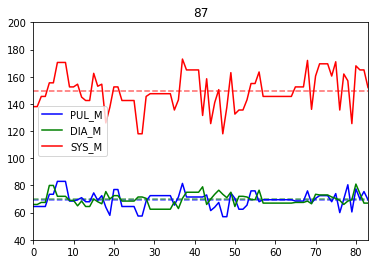

[0. 1. 0. 0.] [ 67.44047619  69.58928571  65.5297619   69.67261905 140.69642857
 149.6547619 ]


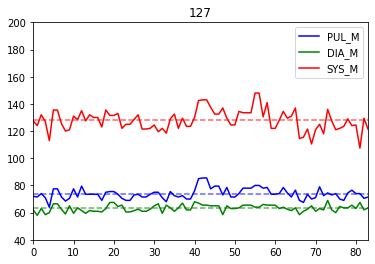

[1. 0. 0. 0.] [ 67.8452381   73.98809524  66.54761905  63.26785714 117.25595238
 127.93452381]


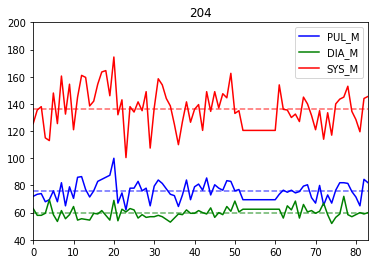

[0. 1. 0. 0.] [ 76.0952381   75.79761905  67.38095238  59.97619048 135.95238095
 136.17261905]


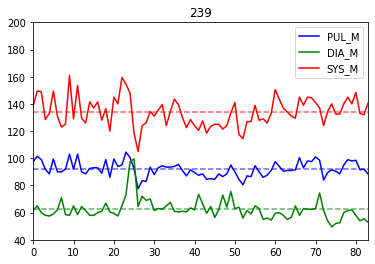

[0. 0. 1. 0.] [ 77.67857143  92.02380952  62.66666667  62.41666667 115.54166667
 134.0297619 ]


In [52]:
indivi_key(87)
indivi_key(127)
indivi_key(204)
indivi_key(239)

極端な例と境界領域が判定ミスしやすい ⇒ 境界付近のデータがConditionをうまく付与できてない？

In [53]:
for i in zip(gen_x[:30], gen_y[:30]):
    print(i[0].mean(axis = 0), i[1])

[ 78.98819779  90.37905552  77.02970318  81.89688561 122.48313768
 135.62563128] 2
[ 76.44973475  86.89770229  72.27385873  71.09356928 119.49761562
 134.26997137] 2
[ 61.65534619  71.21414543  67.71331633  63.6212009  117.57274771
 126.77681539] 0
[ 72.83964715  78.38248254  53.18630609  53.10480864 121.85740484
 125.45899422] 0
[ 59.90037951  69.01506544  69.456964    66.51180856 113.16507619
 122.46030137] 0
[ 80.00254375  86.22323786  68.48822211  68.59976621 115.19505825
 126.71650607] 2
[ 62.41530706  84.22188614  92.60761473  83.14165079 110.75759593
 139.20654257] 0
[ 81.82376447  87.16610922  82.65001457  84.15145833 120.86875192
 130.26381434] 2
[ 73.35349152  85.23758998  63.37786357  59.78056185 117.15207638
 133.4034103 ] 0
[ 61.89463787  71.62888257  59.04153754  52.94397016 117.0383377
 128.05776421] 0
[ 61.2350317   76.57281038  78.95223352  60.33579755 107.35880258
 129.99997892] 0
[ 74.08568432  86.65951088  67.46079194  66.39122651 119.03456928
 135.22243634] 2
[ 71.

([array([2033.,  885.,  751.,  689.,  657.,  647.,  672.,  754.,  850.,
         2062.]),
  array([4365., 1012.,  751.,  635.,  530.,  480.,  467.,  468.,  522.,
          770.]),
  array([5871.,  932.,  604.,  477.,  428.,  361.,  331.,  323.,  314.,
          359.])],
 array([1.46766857e-20, 9.99999990e-02, 1.99999998e-01, 2.99999997e-01,
        3.99999996e-01, 4.99999995e-01, 5.99999994e-01, 6.99999993e-01,
        7.99999992e-01, 8.99999991e-01, 9.99999990e-01]),
 <a list of 3 Lists of Patches objects>)

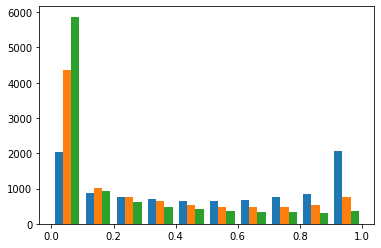

In [54]:
plt.hist(np.random.dirichlet([0.5, 0.3, 0.2], size = 10000))